# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-05-11*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [2]:
isam = xr.open_dataset('F:/Data/case_anqing/April/April_ISAM1.nc')
isam

<xarray.Dataset>
Dimensions:    (time: 720, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    O3_AQ      (time, level, y, x) float32 ...
    O3_HF      (time, level, y, x) float32 ...
    O3_TL      (time, level, y, x) float32 ...
    O3_CZ      (time, level, y, x) float32 ...
    O3_JJ      (time, level, y, x) float32 ...
    O3_OTH     (time, level, y, x) float32 ...
    O3_ICO     (time, level, y, x) float32 ...
    O3_BCO     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [3]:
# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isam.O3_AQ, isam.O3_HF, isam.O3_TL, isam.O3_CZ, 
            isam.O3_JJ, isam.O3_OTH, isam.O3_ICO, isam.O3_BCO]
name_list = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    # L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    L1_dict[f"{name_list[i]}_L1"] = var[:,0,:,:]
    
    # 在 L2 字典中存储 L2 变量
    # L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1 = L1_dict.values()
# AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2 = L2_dict.values()

In [4]:
# 计算区域范围内的平均值
import geopandas as gpd

shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)

for i in range(np.size(isam.latitude,0)):
    for j in range(np.size(isam.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],isam.longitude[i,j],isam.latitude[i,j])==False:
            AQ_L1[:,i,j]=np.nan
            HF_L1[:,i,j]=np.nan
            TL_L1[:,i,j]=np.nan
            CZ_L1[:,i,j]=np.nan
            JJ_L1[:,i,j]=np.nan
            OTH_L1[:,i,j]=np.nan
            ICO_L1[:,i,j]=np.nan
            BCO_L1[:,i,j]=np.nan
            
AQ_L1 = np.nanmean(np.nanmean(AQ_L1,1),1)
HF_L1 = np.nanmean(np.nanmean(HF_L1,1),1)
TL_L1 = np.nanmean(np.nanmean(TL_L1,1),1)
CZ_L1 = np.nanmean(np.nanmean(CZ_L1,1),1)
JJ_L1 = np.nanmean(np.nanmean(JJ_L1,1),1)
OTH_L1 = np.nanmean(np.nanmean(OTH_L1,1),1)
ICO_L1 = np.nanmean(np.nanmean(ICO_L1,1),1)
BCO_L1 = np.nanmean(np.nanmean(BCO_L1,1),1)

In [5]:
chem = xr.open_dataset('F:/Data/case_anqing/April/April_chem.nc')
O3 = chem.O3[:,0,:,:]

for i in range(np.size(chem.latitude,0)):
    for j in range(np.size(chem.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],chem.longitude[i,j],chem.latitude[i,j])==False:
            O3[:,i,j]=np.nan

O3 = np.nanmean(np.nanmean(O3,1),1)

In [6]:
xlsfile = pd.read_excel('F:/Data/case_anqing/April/obsdata/allsite.xlsx')
obs = xlsfile['O3'].values
obs.shape

(720,)

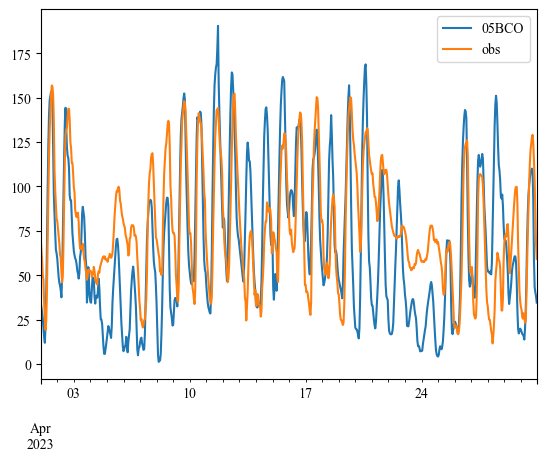

In [7]:
timeindex = pd.date_range('2023-04-01T00','2023-04-30T23',freq='h')

O3_05BCO = AQ_L1+HF_L1+TL_L1+CZ_L1+JJ_L1+OTH_L1+ICO_L1+0.5*BCO_L1
df = pd.DataFrame(
    index=timeindex,
    data={'05BCO':O3_05BCO,'obs':obs}
    )

df.plot()
plt.show()

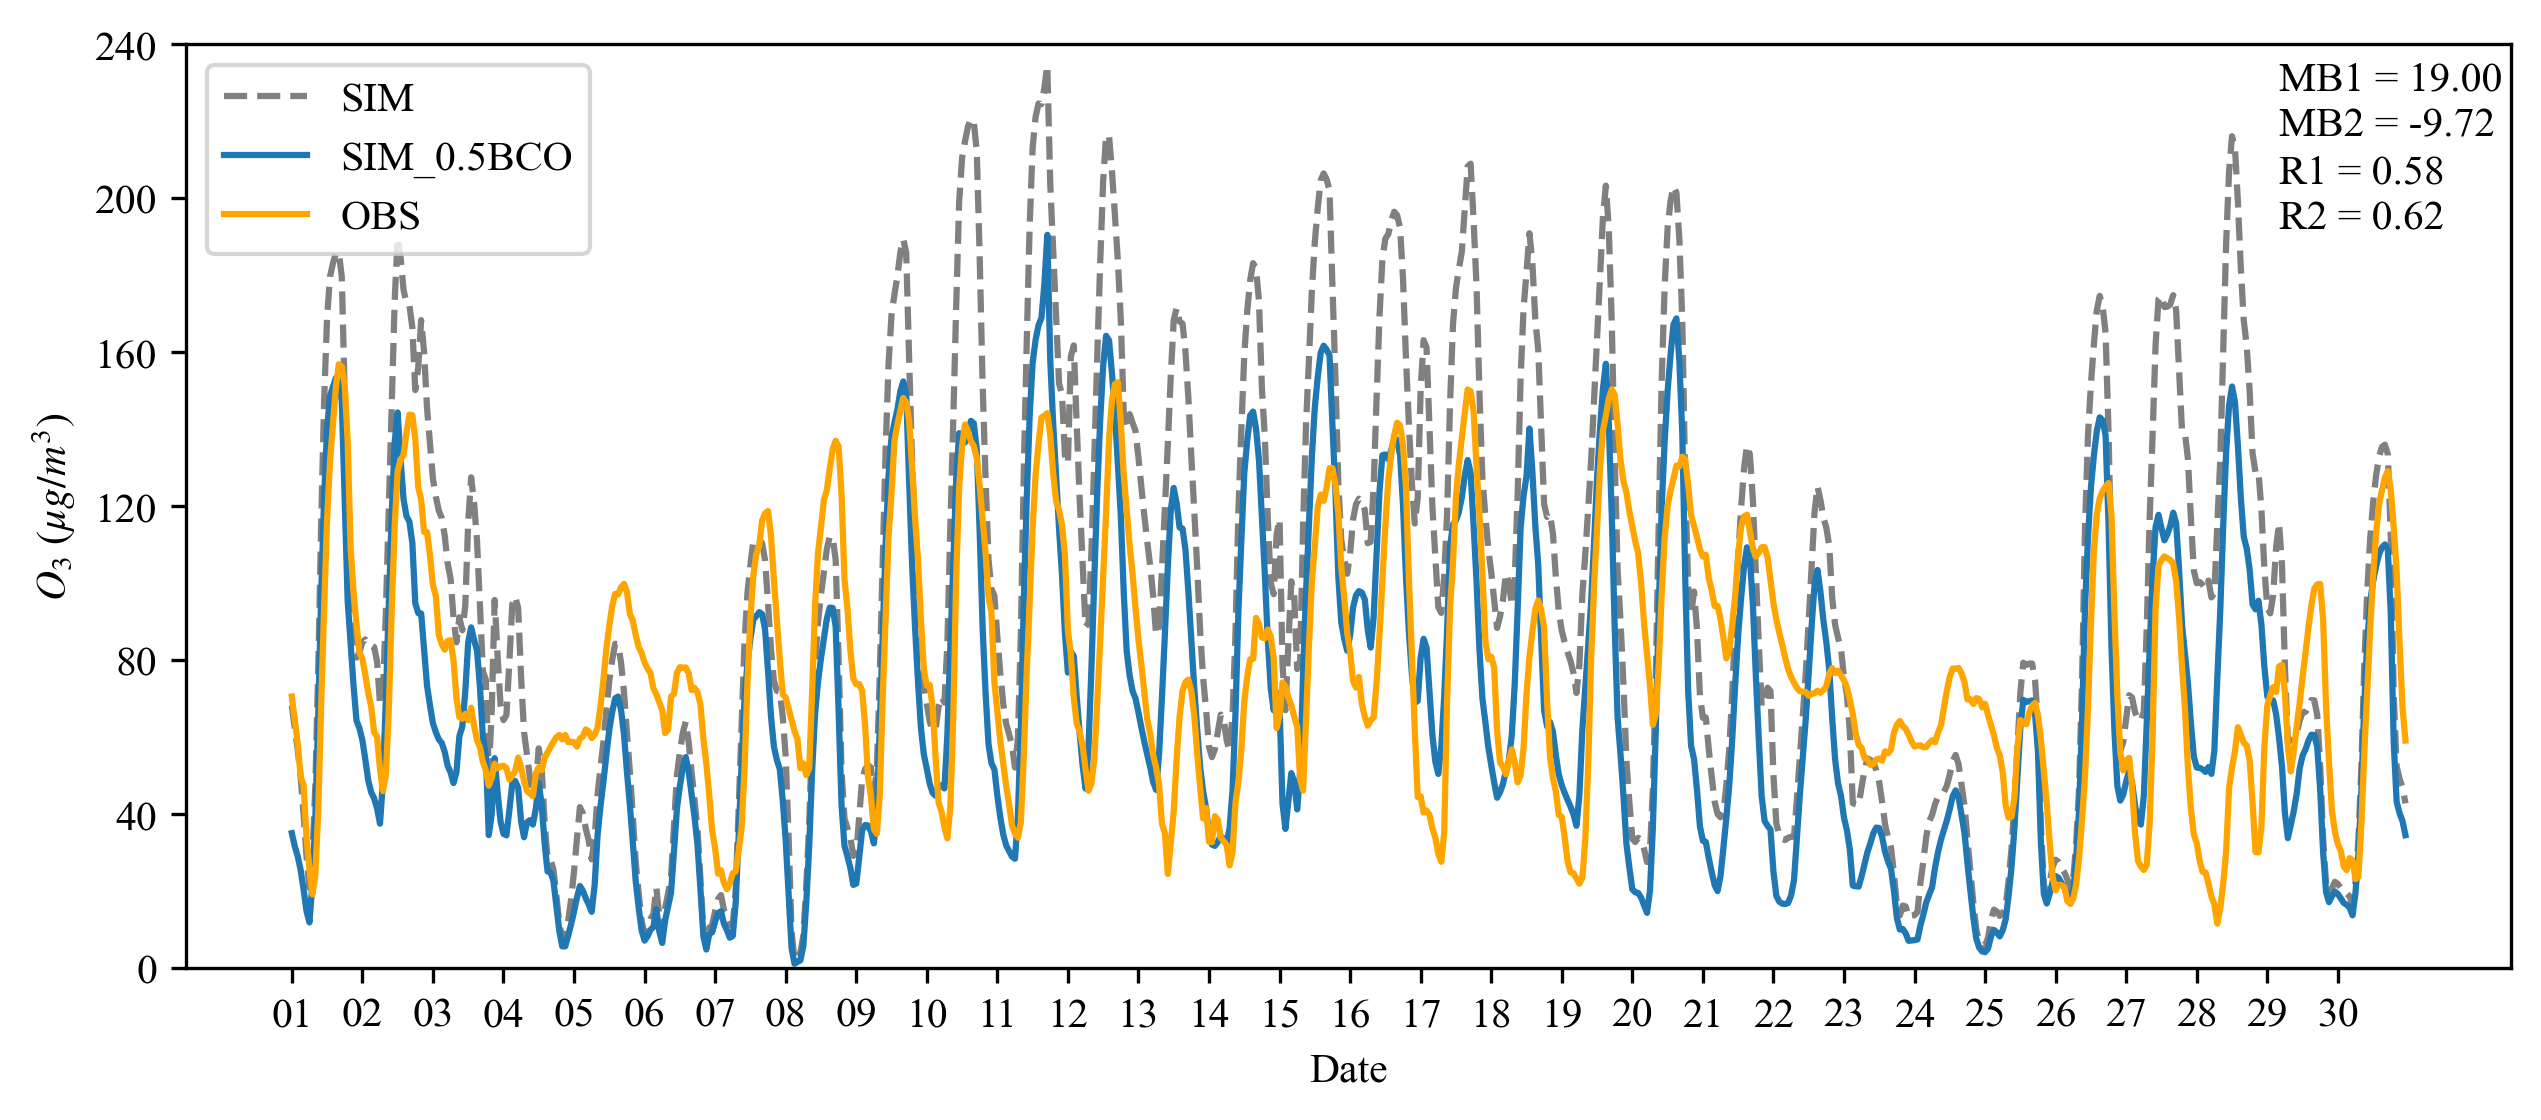

In [31]:

fig = plt.figure(figsize=(10,4),dpi=300)
ax = fig.subplots(1,1)
tstep = np.arange(0,720)
ax.plot(tstep,O3,linestyle='--',color='gray',label='SIM')
ax.plot(tstep,O3_05BCO,linestyle='-',color='tab:blue',label='SIM_0.5BCO')
ax.plot(tstep,obs,linestyle='-',color='orange',label='OBS')

mb1 = np.array(np.mean(O3)-np.mean(obs))
mb2 = np.array(np.mean(O3_05BCO)-np.mean(obs))
r1 = pd.DataFrame({'A':O3,'B':obs}).corr().iloc[0,1]
r2 = pd.DataFrame({'A':O3_05BCO,'B':obs}).corr().iloc[0,1]

ax.text(x=0.9,y=0.95,s='MB1 = '+str(f"{mb1:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.9,y=0.9,s='MB2 = '+str(f"{mb2:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.9,y=0.85,s='R1 = '+str(f"{r1:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.9,y=0.8,s='R2 = '+str(f"{r2:.2f}"),ha='left',transform=ax.transAxes)

ax.legend(loc=2)

ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%d'))
ax.set_yticks(np.arange(0,241,40))
ax.set_ylim(0,240)
ax.set_ylabel('$O_3$ ($\mu$$g/m^3$)')
ax.set_xlabel('Date')

plt.show()

In [8]:
# 设定变量名称循环列表
names = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO',]

# 计算ratio
ratio_L1 = {}
for name in names:
    var_L1 = f"{name}_L1"
    ratio_L1[f"{var_L1}_rt"] = globals()[var_L1] / O3_05BCO
    
AQ_L1_rt, HF_L1_rt, TL_L1_rt, CZ_L1_rt, JJ_L1_rt, OTH_L1_rt, ICO_L1_rt = ratio_L1.values()

BCO_L1_rt = 0.5*BCO_L1/O3_05BCO

## 画图

`Ratio`全时长`L1`,0.5BCO

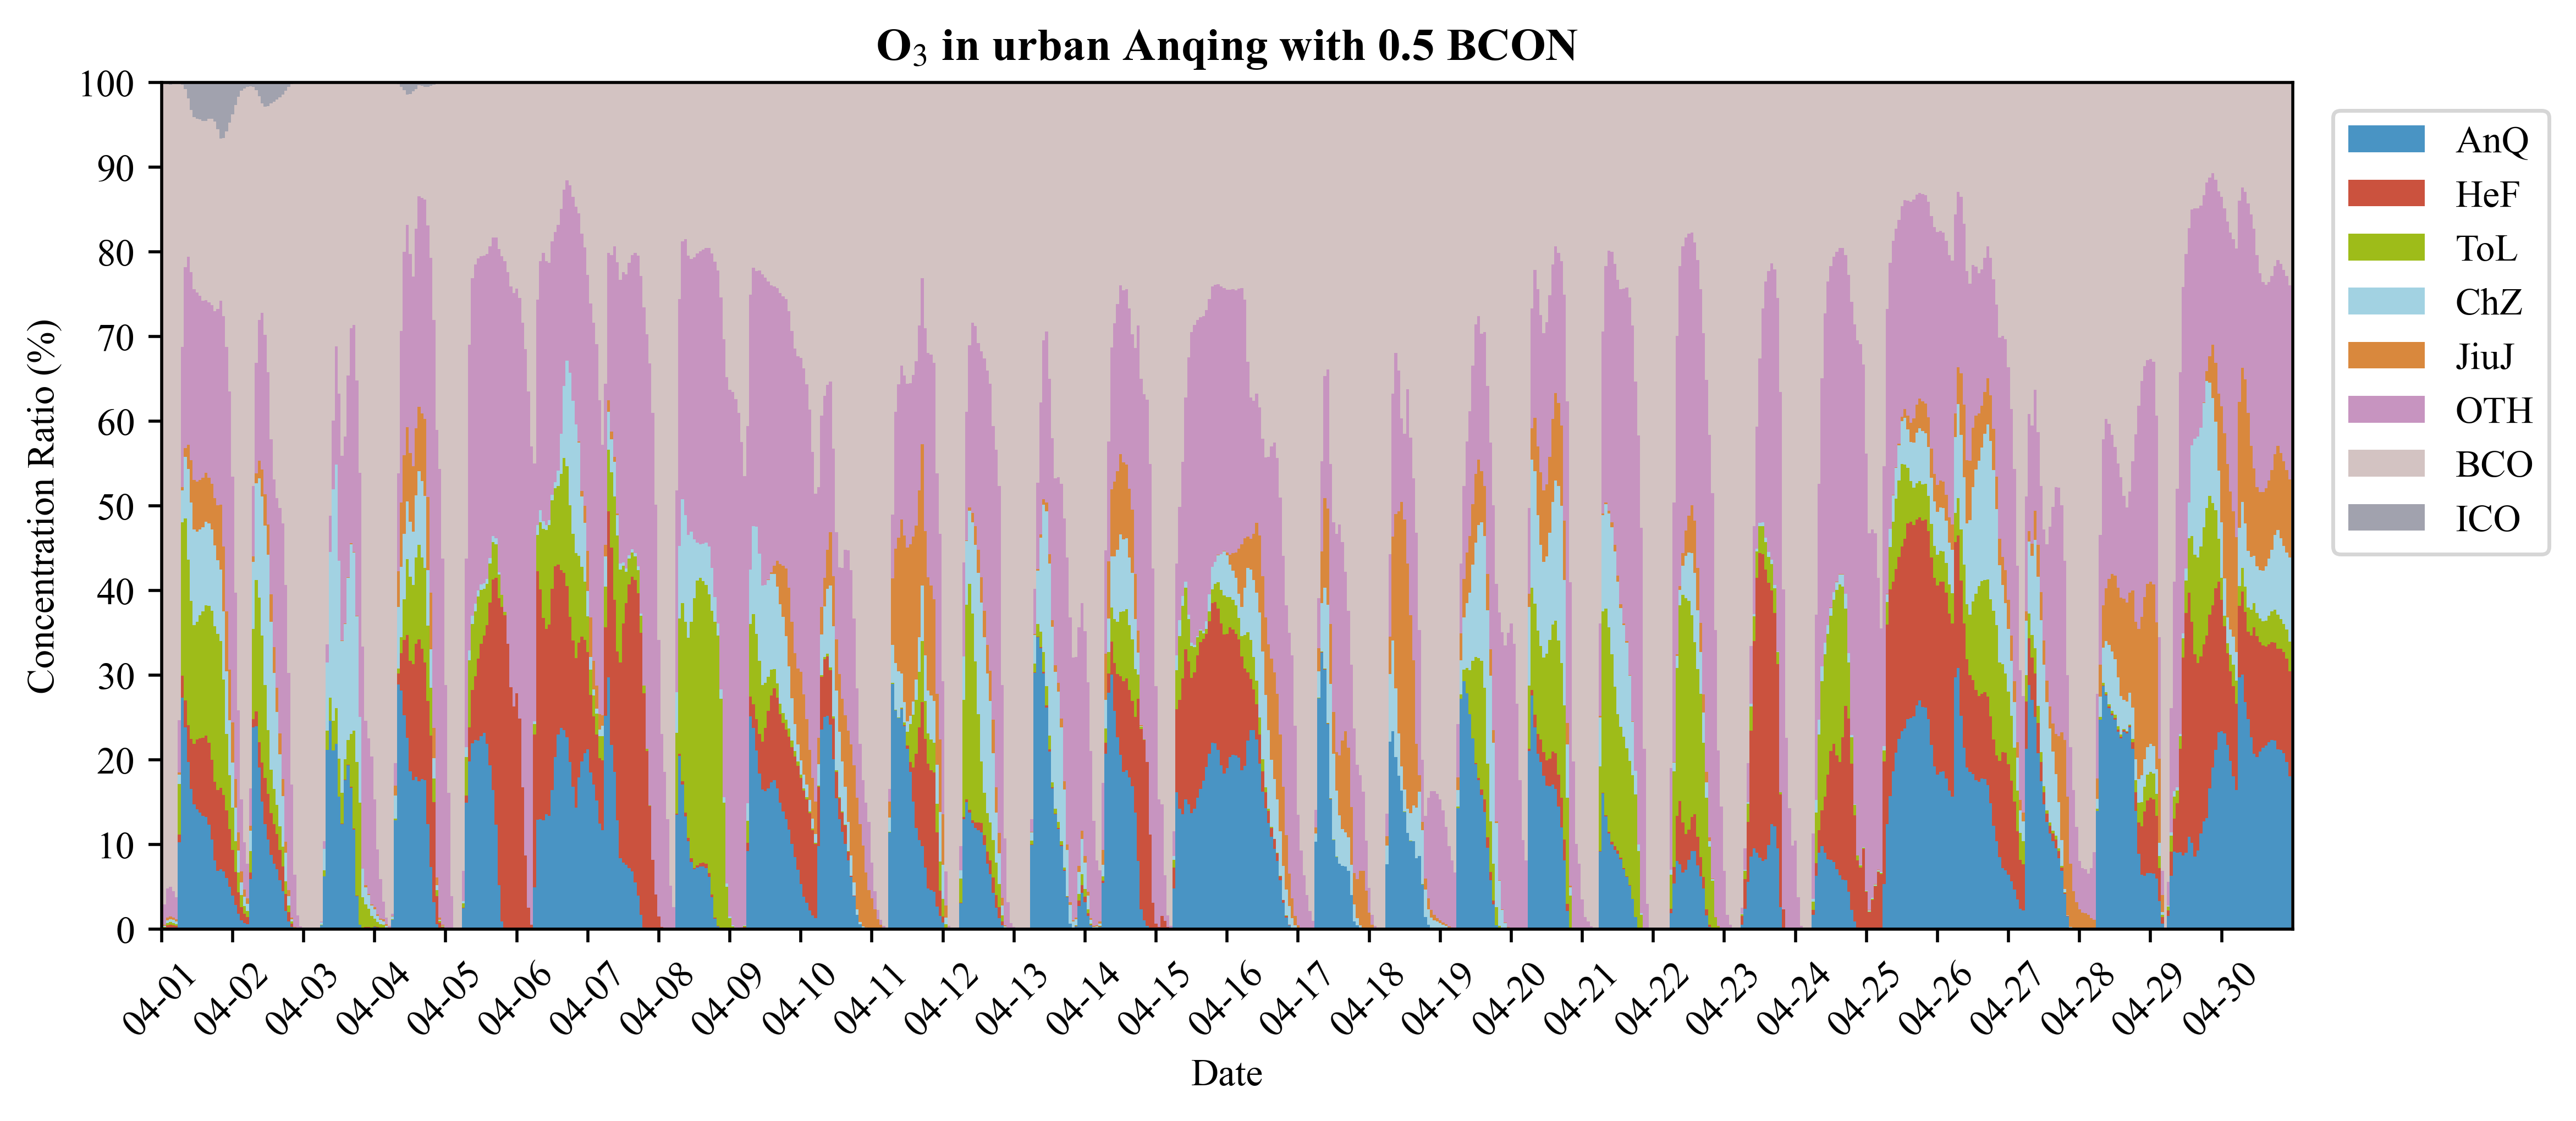

In [35]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,AQ_L1_rt,color=coloraq,width=1)
b2=ax.bar(ts,HF_L1_rt,bottom=AQ_L1_rt,color=colorhf,width=1)
b3=ax.bar(ts,TL_L1_rt,bottom=HF_L1_rt+AQ_L1_rt,color=colortl,width=1)
b4=ax.bar(ts,CZ_L1_rt,bottom=TL_L1_rt+HF_L1_rt+AQ_L1_rt,color=colorcz,width=1)
b5=ax.bar(ts,JJ_L1_rt,bottom=CZ_L1_rt+TL_L1_rt+HF_L1_rt+AQ_L1_rt,color=colorjj,width=1)
b6=ax.bar(ts,OTH_L1_rt,bottom=JJ_L1_rt+CZ_L1_rt+TL_L1_rt+HF_L1_rt+AQ_L1_rt,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,BCO_L1_rt,bottom=OTH_L1_rt+JJ_L1_rt+CZ_L1_rt+TL_L1_rt+HF_L1_rt+AQ_L1_rt,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ICO_L1_rt,bottom=BCO_L1_rt+OTH_L1_rt+JJ_L1_rt+CZ_L1_rt+TL_L1_rt+HF_L1_rt+AQ_L1_rt,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ in urban Anqing with 0.5 BCON',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration Ratio (%)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,1)
ax.set_xlim(0,720)

plt.show()

In [9]:
print('REGION', 'MEAN', 'MIN', 'MAX')
print('Anqing',np.mean(AQ_L1_rt).round(2),np.min(AQ_L1_rt).round(2),np.max(AQ_L1_rt).round(2))
print('Anqing',np.mean(AQ_L1).round(2),np.min(AQ_L1).round(2),np.max(AQ_L1).round(2))

print('Hefei',np.mean(HF_L1_rt).round(2),np.min(HF_L1_rt).round(2),np.max(HF_L1_rt).round(2))
print('Hefei',np.mean(HF_L1).round(2),np.min(HF_L1).round(2),np.max(HF_L1).round(2))

print('Tongl',np.mean(TL_L1_rt).round(2),np.min(TL_L1_rt).round(2),np.max(TL_L1_rt).round(2))
print('Tongl',np.mean(TL_L1).round(2),np.min(TL_L1).round(2),np.max(TL_L1).round(2))

print('Chizh',np.mean(CZ_L1_rt).round(2),np.min(CZ_L1_rt).round(2),np.max(CZ_L1_rt).round(2))
print('Chizh',np.mean(CZ_L1).round(2),np.min(CZ_L1).round(2),np.max(CZ_L1).round(2))

print('Jiuji',np.mean(JJ_L1_rt).round(2),np.min(JJ_L1_rt).round(2),np.max(JJ_L1_rt).round(2))
print('Jiuji',np.mean(JJ_L1).round(2),np.min(JJ_L1).round(2),np.max(JJ_L1).round(2))

print('OTHER',np.mean(OTH_L1_rt).round(2),np.min(OTH_L1_rt).round(2),np.max(OTH_L1_rt).round(2))
print('OTHER',np.mean(OTH_L1).round(2),np.min(OTH_L1).round(2),np.max(OTH_L1).round(2))

print('BCON',np.mean(BCO_L1_rt).round(2),np.min(BCO_L1_rt).round(2),np.max(BCO_L1_rt).round(2))
print('BCON',np.mean(BCO_L1).round(2),np.min(BCO_L1).round(2),np.max(BCO_L1).round(2))

print('ICON',np.mean(ICO_L1_rt).round(2),np.min(ICO_L1_rt).round(2),np.max(ICO_L1_rt).round(2))
print('ICON',np.mean(ICO_L1).round(2),np.min(ICO_L1).round(2),np.max(ICO_L1).round(2))

REGION MEAN MIN MAX
Anqing 0.1 0.0 0.35
Anqing 7.86 0.0 37.4
Hefei 0.07 0.0 0.37
Hefei 4.07 0.0 32.8
Tongl 0.05 0.0 0.35
Tongl 3.61 0.0 31.12
Chizh 0.05 0.0 0.29
Chizh 4.32 0.0 30.87
Jiuji 0.03 0.0 0.32
Jiuji 3.26 0.0 40.75
OTHER 0.23 0.0 0.63
OTHER 15.17 0.0 59.78
BCON 0.48 0.11 1.0
BCON 57.44 1.5 161.42
ICON 0.0 0.0 0.07
ICON 0.16 0.0 6.97
